# **WARNING**

In order for this notebook to run, you must first run the notebook `1_0_generate_noturn_data.ipynb` and generate the file `result/singlegame_results/player10_noturn_results.csv` which contains the optimal policy and value functions for the solved MDPs for different player skill model and epsilon combinatinos. It is also important to make sure that all combinations you want to analyse in this file were generated during this process. 

# 1.0 Notebook Parameters

Please specify the following variables:
1. `project_directory`: your project directory path
2. `epsilon_list`: the list of execution error multiplers (epsilon) that you want to consider in your analysis.
3. `epsilon_list_extremes`: the list of *high* execution error multiplers (epsilon) that you want to consider in your analysis.
4. `player_id`: the players (i.e. skill model) you want to consider in your analysis; use one base model and scale it with different epsilons; this should match whatever was used in `1_0_generate_noturn_data.ipynb`.

In [1]:
# Change this to the project directory path for your computer  
project_directory = '/Users/rachael/Desktop/darts-thesis'

# Set the epsilons that will be considered in this analysis 
epsilon_list = [1,2,3,4,5,6,7,8,9]

# These are the extreme epsilons used for the analysis of much weaker players 
epsilon_list_extremes = [25,50,100]

# Set the ID of the player skill models you want to use 
    # 10 - symmetric DB skill model that we were using up until now 
    # ? - "average pro" skill model generated by H & W 
player_id = 10 

# 2.0 Notebook Setup

Import libraries and run prerequisites.

In [2]:
# Import and configure modules from this project

import os

os.chdir(project_directory)

import function_init_simple_mdp as imdp
import function_plot_board as ib
import function_init_board as fb

In [3]:
# Import and configure external modules

import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=300)
np.set_printoptions(threshold=300)

import pandas as pd

import numpy as np
import math
import scipy.io as sio
from scipy.stats import multivariate_normal

# Plotting 
import matplotlib.pyplot as plt

import seaborn as sns
#sns.set_theme()   # uncomment this if you want seasborn theme


In [4]:
# Helper functions for plotting


# KDE plot creator
def createKde(data, x, y, title="", ax=None, cmap='Blues', levels=10, alpha=1):
    if ax == None:
        ax = plt.gca()
    sns.kdeplot(data=data, x=x, y=y, cmap=cmap, fill=True, levels=levels, ax=ax, alpha=alpha)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ib.plot_basic_board(axes=ax)
    ax.title.set_text(title)


# Get player's gaussian distribution 
def get_gaussian(x_val,y_val,error_multiplier,player_index=7):
  
  result_dir = fb.data_parameter_dir + '/grid_full'
  if not os.path.isdir(result_dir):
      os.makedirs(result_dir)
  player_parameter = sio.loadmat('./data_parameter/ALL_Model_Fits.mat')
  
  ## 1mm-width grid of 341*341 aiming locations (a sqaure enclosing the circle dart board)
  [xindex, yindex, xgrid, ygrid, grid_num] = fb.get_1mm_grid()

  xi = np.where(xgrid==x_val)[0][0]
  yi = np.where(xgrid==y_val)[0][0]

  ## select the proper Gaussian distribution according to the area to which the aiming location belongs
  mu = [xgrid[xi], ygrid[yi]]
  score, multiplier = fb.get_score_and_multiplier(mu)
  if (score==60 and multiplier==3): ##triple 20
      covariance_matrix = player_parameter['ModelFit_T20'][0, player_index][2] * error_multiplier
  elif (score==57 and multiplier==3): ##triple 19
      covariance_matrix = player_parameter['ModelFit_T19'][0, player_index][2] * error_multiplier
  elif (score==54 and multiplier==3): ##triple 18
      covariance_matrix = player_parameter['ModelFit_T18'][0, player_index][2] * error_multiplier
  elif (score==51 and multiplier==3): ##triple 17
      covariance_matrix = player_parameter['ModelFit_T17'][0, player_index][2] * error_multiplier
  elif (score==50 and multiplier==2): ##double bull
      covariance_matrix = player_parameter['ModelFit_B50'][0, player_index][2] * error_multiplier
  else:
      covariance_matrix = player_parameter['ModelFit_All_Doubles'][0, player_index][2] * error_multiplier
  
  return mu,covariance_matrix


# Plot gaussian dsitribution 
def plot_gaussian(x_val,y_val,error_multiplier,player_index=7,xlim=(-200,200),ylim=(-200,200),figsize = (8,8),ax=None,title=''):
  
  mu,covariance_matrix = get_gaussian(x_val,y_val,error_multiplier,player_index=player_index)
  rv = multivariate_normal(mu, covariance_matrix)
  
  x, y = np.mgrid[-200:200:1, -200:200:1]
  pos = np.dstack((x, y))
  
  axes = ib.plot_basic_board(xlim=xlim,ylim=ylim,figsize = figsize,axes=ax)
  #axes.plot(x_val, y_val, "or")

  ax.title.set_text(title)
  
  fi = axes.contourf(x, y, rv.pdf(pos), 20, cmap='Greens')


# 3.0 Load Data

In [5]:
# Load data
df = pd.read_csv('result/singlegame_results/player10_noturn_results.csv')
df = df.loc[df.player==player_id]

# Read only the relevant columns - note that this will result in duplicates if you include multiple players 
df = df[['epsilon','tokens','score','optimal_value','optimal_policy']]

# Add boolean column to indicate whether the policy uses tokens or not 
df['policy_is_token'] = df['optimal_policy'] >= imdp.throw_num

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

In [6]:
# Create dataframes for each individual epsilon in main list
epsilon_dfs = []

for epsilon in epsilon_list:
    temp = df.loc[df.epsilon==epsilon].set_index('score')['optimal_policy_name'].copy()
    epsilon_dfs.append(temp)

# Create dataframes for each of the extreme epsilons
epsilon_dfs_extremes = []

for epsilon in epsilon_list_extremes:
    temp = df.loc[df.epsilon==epsilon].set_index('score')['optimal_policy_name'].copy()
    epsilon_dfs_extremes.append(temp)


In [7]:
# [For normal epsilon] expand the above dataframes to include the coordinates of each action 
epsilon_dfs_expanded = []

for e in range(len(epsilon_list)):

    epsilon = epsilon_list[e]

    temp_list = []
    for action in epsilon_dfs[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded.append(temp)

# [For extreme epsilon] expand the above dataframes to include the coordinates of each action 
epsilon_dfs_expanded_extremes = []

for e in range(len(epsilon_list_extremes)):

    epsilon = epsilon_list_extremes[e]

    temp_list = []
    for action in epsilon_dfs_extremes[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded_extremes.append(temp)

# 4.0 Policy Heatmaps

### 4.1 Heatmaps for Normal Epsilon

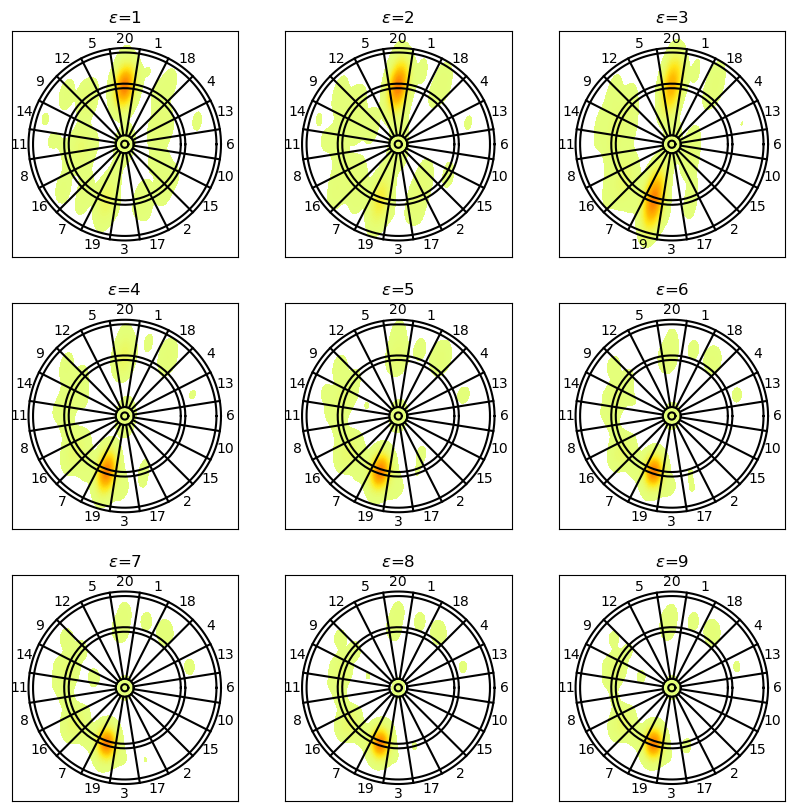

In [8]:
# Color parameters
cmap = 'Wistia'
alpha = 1
levels = 50

# Figure size
fig, ax = plt.subplots(3, 3,figsize=(10,10))

# Plot KDEs 
for e in range(len(epsilon_dfs_expanded)):

    row = math.floor(e/3)
    col = e%3 

    createKde(data=epsilon_dfs_expanded[e], x='x', y='y', title=f"$\epsilon$={epsilon_list[e]}", ax=ax[row,col], cmap=cmap, levels=levels, alpha=alpha)



### 4.2 Heatmaps for High Epsilon


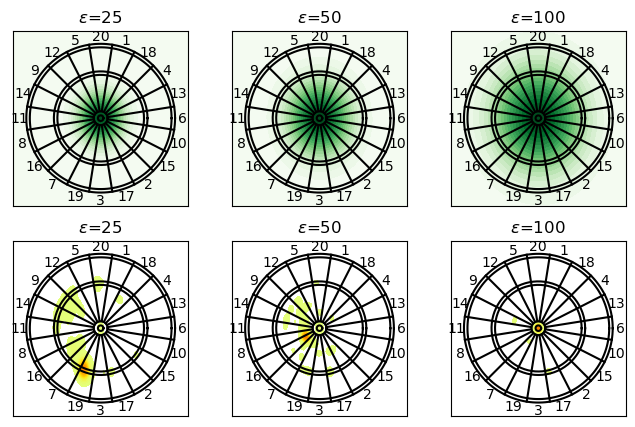

In [9]:
cmap = 'Wistia'
alpha = 1
levels = 30

x_val=0
y_val=0

fig, ax = plt.subplots(2, 3, figsize=(8,5))

for e in range(len(epsilon_list_extremes)):
    col = e % 3
    plot_gaussian(x_val,y_val,epsilon_list_extremes[e],player_index=10,xlim=(-200,200),ylim=(-200,200),ax=ax[0,col],title='$\epsilon$={}'.format(epsilon_list_extremes[e]))
    createKde(data=epsilon_dfs_expanded_extremes[e], x='x', y='y', title="$\epsilon$={}".format(epsilon_list_extremes[e]), ax=ax[1,col], cmap=cmap, levels=levels, alpha=alpha)

    #plt.tight_layout()

# 5.0 Policy Token Usage

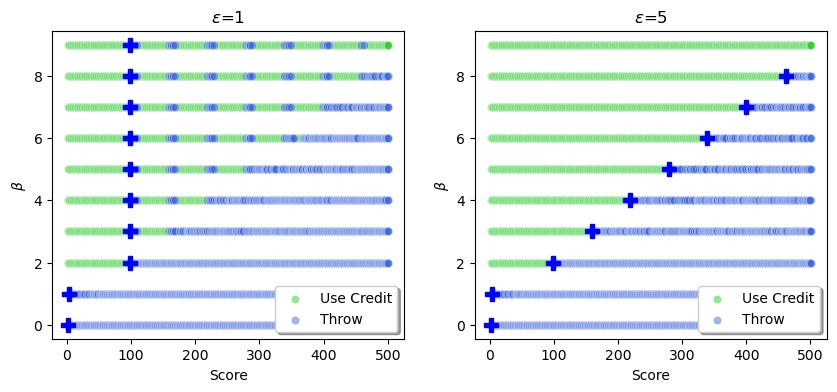

In [10]:
###################################################
#            VARIABLES

epsilon1 = 1
epsilon2 = 5


###################################################

# Figure Size 
figure, ax = plt.subplots(1, 2,figsize=(10,4))

# Get dataset that only has feasible states that have optimal policy values (remove noise)
df_temp = df[df.optimal_policy != -1]


####### Epsilon 1 Code #######

# Get optimal policy for epsilon player 
df_actions1 = df_temp[df_temp.epsilon == epsilon1]

# Plot credit actions in green 
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[0])

# Plot throw actions in blue 
fig = sns.scatterplot(data=df_actions1.loc[df_actions1.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[0])

# Add axis labels, legend and title 
fig = ax[0].set_ylabel(r'$\beta$')
fig = ax[0].set_xlabel(r'Score')
fig = ax[0].set_title(rf'$\epsilon$={epsilon1}')
fig = ax[0].legend(loc='lower right', fancybox=True, shadow=True)

# Plot the extreme cases of token usage
for t in range(10):
    # Max score when a token was used
    max_token = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==True)].score.max()
    # ax[0].plot(max_token,t,marker='X',markersize=10,color='green') # uncomment if you want to plot 

    # Min score where a player threw instead of using a token 
    min_throw = df_actions1.loc[(df_actions1.tokens==t) & (df_actions1.policy_is_token==False)].score.min()
    ax[0].plot(min_throw,t,marker='P',markersize=10,color='blue') # plot 

####### Epsilon 2 Code #######

# Get optimal policy for epsilon player 
df_actions2 = df_temp[df_temp.epsilon == epsilon2]

# Plot credit actions in green 
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[1])

# Plot throw actions in blue 
fig = sns.scatterplot(data=df_actions2.loc[df_actions2.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[1])

# Add axis labels, legend and title 
fig = ax[1].set_ylabel(r'$\beta$')
fig = ax[1].set_xlabel(r'Score')
fig = ax[1].set_title(rf'$\epsilon$={epsilon2}')
fig = ax[1].legend(loc='lower right', fancybox=True, shadow=True)

# Plot the extreme cases of token usage
for t in range(10):
    # Max score when a token was used
    max_token = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==True)].score.max()
    # ax[0].plot(max_token,t,marker='X',markersize=10,color='green') # uncomment if you want to plot 

    # Min score where a player threw instead of using a token 
    min_throw = df_actions2.loc[(df_actions2.tokens==t) & (df_actions2.policy_is_token==False)].score.min()
    ax[1].plot(min_throw,t,marker='P',markersize=10,color='blue') # plot 

